In [5]:
import sys
import csv
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr


###############################################################################
# Program parameters
###############################################################################
#current version
version_string = 'v1.0'

#types
READ_TYPE  = 0
WRITE_TYPE = 1
RMW_TYPE   = 2

###############################################################################
# Read Trace CSV
###############################################################################
df = pd.read_csv('trace_nn_10000.csv')

#convert to numpy array
addr = df.Addr.to_numpy()
rw_type = df.R0_W1.to_numpy()
num_rows = len(addr)
if (num_rows == 0):
    print("Nothing to plot... Quitting...")
    sys.exit(0)
    
args_min_x = 0
#args_max_x = 340000
args_max_x = num_rows
args_read = 1
args_write = 1
args_const = 1
args_rmw = 0
args_alpha_read = 0.15
args_alpha_write = 0.15
args_alpha_rmw = 0.15
#args_max_y = 1000000000000000
args_max_y = -1

###############################################################################
# Apply Filters
###############################################################################

entries = {'R0_W1':[], 'Addr':[]}
curr_idx = args_min_x
last_type = -1
last_addr = -1
while curr_idx < args_max_x:
    curr_addr = addr[curr_idx]
    curr_type = rw_type[curr_idx]
    curr_idx += 1
    
    if (args_max_y != -1) and (curr_addr > args_max_y):
        continue
    
    # apply --read arg filter
    if (args_read == 0) and (curr_type == READ_TYPE):
        continue

    # apply --write arg filter
    if (args_write == 0) and (curr_type == WRITE_TYPE):
        continue
    
    # apply --const filter
    if (args_const == 0) and (last_type == curr_type) and (last_addr == curr_addr):
        continue

    # apply --rmw filter
    if (args_rmw == 1) and (last_addr == curr_addr) and  \
            (last_type == READ_TYPE) and (curr_type == WRITE_TYPE):
        #pop previous entry
        entries['R0_W1'].pop()
        entries['Addr'].pop()
        #add new entry
        entries['R0_W1'].append(RMW_TYPE)
        entries['Addr'].append(curr_addr)
    else:
        entries['R0_W1'].append(curr_type)
        entries['Addr'].append(curr_addr)
    last_addr = curr_addr
    last_type = curr_type
    
# create a new DataFrame object with filtered entries
df = pd.DataFrame(data=entries)

In [6]:
# sort by address (required by the next step of address compression)
df.sort_values("Addr", kind='mergesort', inplace=True)

# function for reducing the gap between addresses
def comp_addr(curr_addr):
    curr_gap = curr_addr - comp_addr.act
    if(curr_gap > comp_addr.MAX_GAP):
        comp_addr.conv += comp_addr.MAX_GAP
        print(comp_addr.conv)
    else:
        comp_addr.conv += curr_gap
    comp_addr.act = curr_addr
    return comp_addr.conv

# static initial values for the comp_addr function 
comp_addr.act = 0
comp_addr.conv = 0
comp_addr.MAX_GAP = 512

# replace previous addresses with compressed addresses
df.Addr = df.Addr.apply(comp_addr)

512
1144
1838
2910
5205
24389
24909
25733
26321
27241
27761
28585
29173
30093
30613
31437
32025
32945
33465
34289
34877
35797
36317
37141
37729
38649
39169
39993
40581
41501
42021
42845
43433
44353
44873
45697
46285
47205
47725
48549
49137
50057
50577
51401
51989
52909
53429
54253
54841
55761
56281
57105
57693
58613
59133
59957
60545
61465
61985
62809
63397
64317
65333
65853
66677
67265
68185
69201
69721
70545
71133
72053
73069
73589
74413
75001
75921
76937
77457
78281
78869
79789
80805
81325
82149
82737
83657
84673
85193
86017
86605
87525
88541
89061
89885
90473
91393
92409
92929
93753
94341
95261
96277
96797
97621
98209
99129
99649
101137
101961
102521
103113
103713
104489
105145
106790
107307
107827
108347
109112
109643
110750
112302
112822
114630
115430
115990
116518
118110
118934
119446
120410
120922
121434
121946
122466
122978
123494
124010
124530
125050
125570
126090
126610
127130
128139
128659
129950
130782
131648
132160
132672
133184
133696
134392
135139
136195
137051
137563
1

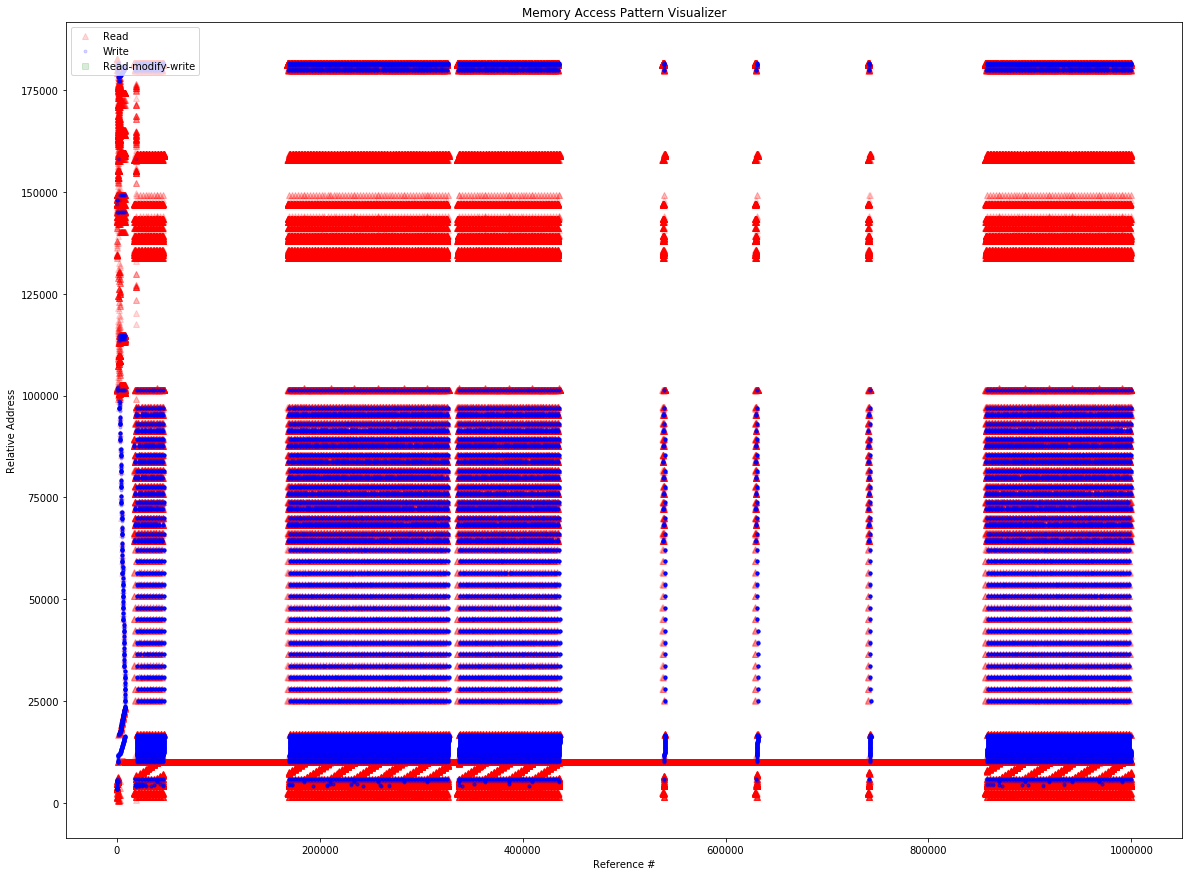

In [7]:
###############################################################################
# Plot results
###############################################################################
# seperate reads, writes and read-modify-writes
dfR = df.loc[df.R0_W1 == READ_TYPE]
dfW = df.loc[df.R0_W1 == WRITE_TYPE]
dfRMW = df.loc[df.R0_W1 == RMW_TYPE]

# plot
plt.figure(figsize=(20,15))
plt.title("Memory Access Pattern Visualizer")
plt.xlabel("Reference #")
plt.ylabel("Relative Address")
plt.plot(dfR.index, dfR.Addr, 'r^', alpha=args_alpha_read, label='Read')
plt.plot(dfW.index, dfW.Addr, 'b.', alpha=args_alpha_write, label='Write')
plt.plot(dfRMW.index, dfRMW.Addr, 'gs', alpha=args_alpha_rmw, label='Read-modify-write')
plt.legend(loc='upper left')
plt.show()


In [8]:
dfc = df.sort_index()
maxX = dfc.shape[0]
maxAddr = comp_addr.conv
dfcAddr = dfc.Addr.to_numpy()
dfcRW = dfc.R0_W1.to_numpy()
x_step = 8000
y_step = 15000

numBkts = (int)(np.ceil(maxAddr / y_step))
print("Number of buckets:", numBkts, '\n')

addrBkt = np.zeros((numBkts, x_step), dtype=int)
rwBkt = np.zeros((numBkts, x_step), dtype=int)
rdStride = np.zeros(x_step, dtype = int)
wrStride = np.zeros(x_step, dtype = int)
mxStride = np.zeros(x_step, dtype = int)
rdAddr = np.zeros(x_step, dtype = int)
wrAddr = np.zeros(x_step, dtype = int)
mxAddr = np.zeros(x_step, dtype = int)
xIdx = np.zeros(x_step, dtype = int)

plt.figure(figsize=(20,15))
ax = plt.gca()

for base_x in range(0, maxX, x_step):
    elemCnt = np.zeros(numBkts, dtype = int)
    for x in range(x_step):
        ea = dfcAddr[base_x + x]
        rw = dfcRW[base_x + x]
        bktIdx = (int)(np.floor(ea / y_step))
        cnt = elemCnt[bktIdx]
        addrBkt[bktIdx][cnt] = ea
        rwBkt[bktIdx][cnt] = rw
        elemCnt[bktIdx] = cnt + 1
        xIdx[x] = x


    for bkt in range(numBkts):    
        #print("[", bkt*y_step, "-", (bkt+1)*y_step - 1, "]", "elem:", elemCnt[bkt])
        rdCnt = 0
        wrCnt = 0
        mxCnt = 0
        lastRdAddr = -1
        lastWrAddr = -1
        lastMxAddr = -1
        rdMean = None
        wrMean = None
        mxMean = None
        rdStd = None
        wrStd = None
        mxStd = None
        rdCorr = None
        wrCorr = None
        mxCorr = None
        for e in range(elemCnt[bkt]):
            addr = addrBkt[bkt][e]
            if (rwBkt[bkt][e] == READ_TYPE):  #read
                if(lastRdAddr != -1):
                    rdAddr[rdCnt] = addr
                    rdStride[rdCnt] = addr - lastRdAddr
                    rdCnt = rdCnt + 1
                lastRdAddr = addr
            elif (rwBkt[bkt][e] == WRITE_TYPE):  #write
                if(lastWrAddr != -1):
                    wrAddr[wrCnt] = addr
                    wrStride[wrCnt] = addr - lastWrAddr
                    wrCnt = wrCnt + 1
                lastWrAddr = addr
            if(lastMxAddr != -1):
                mxAddr[mxCnt] = addr
                mxStride[mxCnt] = addr - lastMxAddr
                mxCnt = mxCnt + 1
            lastMxAddr = addr
        if(rdCnt != 0):
            rdMean = np.mean(rdStride[0:rdCnt])
            rdStd = np.std(rdStride[0:rdCnt])
            rdCorr,_ = pearsonr(xIdx[0:rdCnt], rdAddr[0:rdCnt])
        if(wrCnt != 0):
            wrMean = np.mean(wrStride[0:wrCnt])
            wrStd = np.std(wrStride[0:wrCnt])
            wrCorr,_ = pearsonr(xIdx[0:wrCnt], wrAddr[0:wrCnt])
        if(mxCnt != 0):
            mxMean = np.mean(mxStride[0:mxCnt])
            mxStd = np.std(mxStride[0:mxCnt])
            mxCorr,_ = pearsonr(xIdx[0:mxCnt], mxAddr[0:mxCnt])
        #print("RdCnt:", rdCnt, "WrCnt:", wrCnt, "MxCnt:", mxCnt)
        #print("RdMean:", rdMean, "WrMean:", wrMean, "MxMean:", mxMean)
        #print("RdStd:", rdStd, "WrStd:", wrStd, "MxStd:", mxStd)
        #print("RdCorr:", rdCorr, "WrCorr:", wrCorr, "MxCorr:", mxCorr)


        #verdict
        vRWType = None    #0:read-only       1: write-only        2: mixed
        if(wrCnt == 0):
            if(rdCnt == 0):
                vRWType = None     #no read, no write
            else:
                vRWType = 0        #only read
        else:
            rdRatio = rdCnt / wrCnt
            if (rdRatio > 5.6667):     #more than 85% read. Assume read-only
                vRWType = 0
            elif (rdRatio < 0.1765):   #more than 85% write. Assume write-only
                vRWType = 1
            else:
                vRWType = 2          #mixed access

        if(vRWType == 0):
            if (rdCorr > 0.8 or rdCorr < -0.8):
                pstr = "Seq read\nWSS: " + str(rdCnt * 4)
            else:
                pstr = "Rand read\nWSS: " + str(rdCnt * 4)
        elif(vRWType == 1):
            if (wrCorr > 0.8 or wrCorr < -0.8):
                pstr = "Seq write\nWSS: " + str(wrCnt * 4)
            else:
                pstr = "Rand write\nWSS: " + str(wrCnt * 4)
        elif(vRWType == 2):
            if (rdCorr > 0.8 or rdCorr < -0.8):
                pstr = "Seq read"
            else:
                pstr = "Rand read"
            if (wrCorr > 0.8 or wrCorr < -0.8):
                pstr = pstr + "\nSeq write"
            else:
                pstr = pstr + "\nRand write"
        else:
            pstr = "NA"
        px = base_x
        py = bkt*y_step
        ax.add_patch(patches.Rectangle((px,py),x_step,y_step,linewidth=1,edgecolor='k',facecolor='none'))
        plt.text(px+x_step/2, py + y_step/2, pstr, horizontalalignment='center', verticalalignment='center', fontsize = 15)

    
# plot
plt.title("Memory Access Pattern Visualizer")
plt.xlabel("Reference #")
plt.ylabel("Relative Address")
plt.plot(dfR.index, dfR.Addr, 'r^', alpha=args_alpha_read, label='Read')
plt.plot(dfW.index, dfW.Addr, 'b.', alpha=args_alpha_write, label='Write')
plt.plot(dfRMW.index, dfRMW.Addr, 'gs', alpha=args_alpha_rmw, label='Read-modify-write')
plt.legend(loc='upper left')
plt.show()

Number of buckets: 13 



ValueError: x and y must have length at least 2.

ValueError: Image size of 13392082x152887547 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x1080 with 1 Axes>

Number of buckets: 15
Max X: 118000

Max Bkt: 40000
Change detected at: {'s': 0, 'e': 10000}
Change detected at: {'s': 10000, 'e': 50000}
Change detected at: {'s': 50000, 'e': 118000}


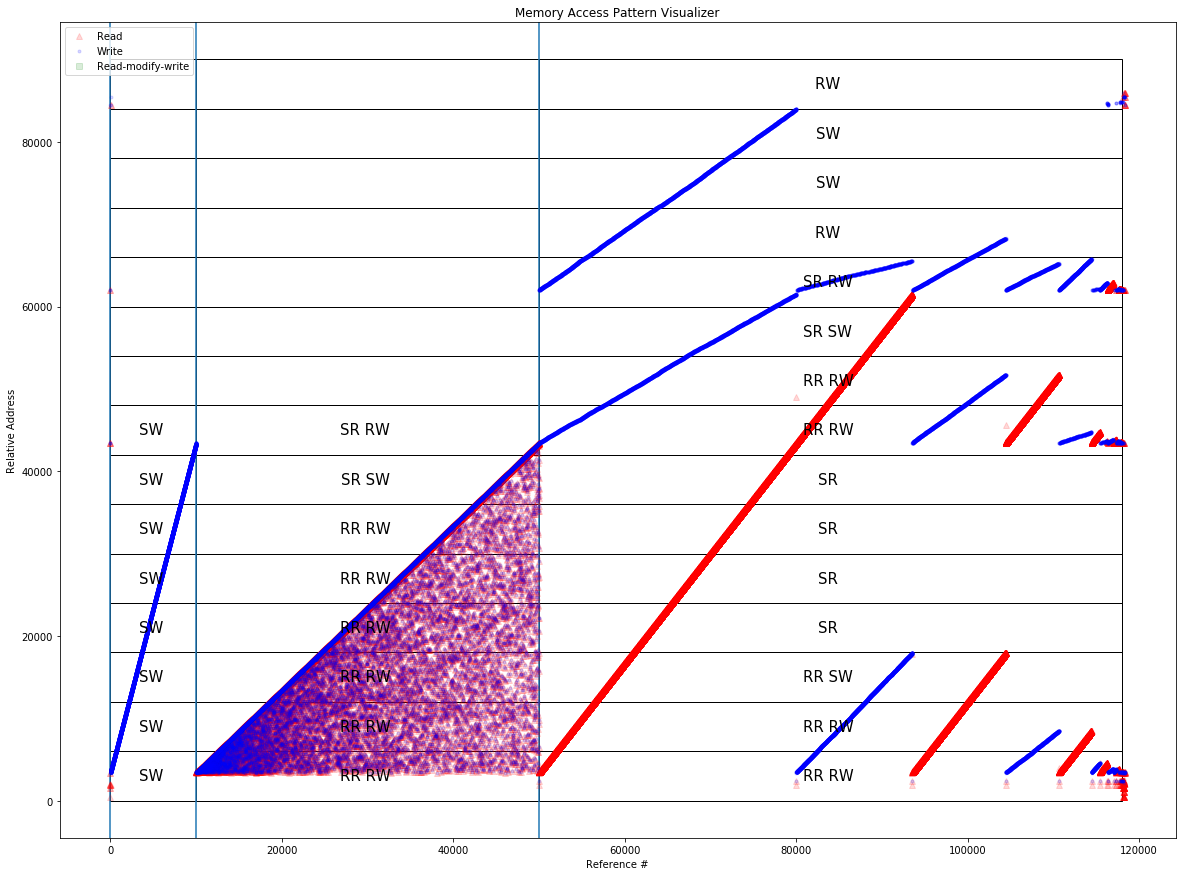

In [111]:
from enum import Enum

X_STEP = 500
Y_STEP = 6000
ELEM_TH = 10         # minimum number of elements in bucket to be considered for calculation
RW_RATIO_TH = 0.85    # read/write ratio threashold
ACCESS_SIZE = 8        # size of each access (TODO: Instead of assuming, get from PIN)
CORR_TH = 0.85       # correlation threadhold for determining rand/seq
CHANGE_TH = 0.1      # Consider a change in x axis

class RWType(Enum):
    SEQ  = 1
    RAND = 2
    NA   = 3

class AType(Enum):
    READ  = 1
    WRITE = 2
    MIXED = 3
    NA    = 4

def createBuckets(inAddr, inRW, start_index, end_index, y_step, addrBkts, rwBkts, numBkts):
    elemCnt = np.zeros(numBkts, dtype = int)
    for x in range(start_index, end_index):
        ea = inAddr[x]
        rw = inRW[x]
        bktIdx = (int)(ea / y_step)
        cnt = elemCnt[bktIdx]
        addrBkts[bktIdx][cnt] = ea
        rwBkts[bktIdx][cnt] = rw
        elemCnt[bktIdx] = cnt + 1
    return elemCnt

def getPattern(addrBkt, cnt):
    if cnt < ELEM_TH:        # not enough elements to decide
        return RWType.NA
    corr,_ = pearsonr(xIdx[0:cnt], addrBkt[0:cnt])
    if corr >= CORR_TH or corr <= (-1*CORR_TH):
        return RWType.SEQ
    return RWType.RAND

def resToString(res):
    retVal = "";
    if res['rdType'] == RWType.SEQ:
        retVal = retVal + "SR "
    elif res['rdType'] == RWType.RAND:
        retVal = retVal + "RR "
    if res['wrType'] == RWType.SEQ:
        retVal = retVal + "SW "
    elif res['wrType'] == RWType.RAND:
        retVal = retVal + "RW "
    return retVal

def countRW(rwArr, start_index, end_index):
    rdCnt = 0
    wrCnt = 0
    for i in range(start_index, end_index):
        if rwArr[i] == READ_TYPE:
            rdCnt = rdCnt + 1
        elif rwArr[i] == WRITE_TYPE:
            wrCnt = wrCnt + 1
    return rdCnt, wrCnt            

def isChanged(rd1, rd2, wr1, wr2):
    diff = abs(rd1 - rd2) + abs(wr1 - wr2)
    diffRatio = diff / (rd1 + wr1)
    if diffRatio >= CHANGE_TH:
        return True, diffRatio
    return False, diffRatio
    

def analyzeBucket(addrBkt, rwBkt, cnt):
    retVal = {'rdType': RWType.NA, 'wrType': RWType.NA, 'accType': AType.NA, 'rdSz': 0, 'wrSz': 0}
    
    # check if enough elements in bucket
    if cnt < ELEM_TH:
        return retVal
    
    # separate read/write
    rdCnt = 0
    wrCnt = 0
    for i in range(cnt):
        if rwBkt[i] == READ_TYPE:
            rdAddr[rdCnt] = addrBkt[i]
            rdCnt = rdCnt + 1
        elif rwBkt[i] == WRITE_TYPE:
            wrAddr[wrCnt] = addrBkt[i]
            wrCnt = wrCnt + 1
    if rdCnt < ELEM_TH and wrCnt < ELEM_TH:    # too few elements to decide
        return retVal
    
    if rdCnt < ELEM_TH:                        # Write only
        retVal['accType'] = AType.WRITE
    elif wrCnt < ELEM_TH:                      # Read only
        retVal['accType'] = AType.READ
    else:                                      # Both read and write more than ELEM_TH. Check ratio
        ratio = rdCnt / cnt
        if ratio >= RW_RATIO_TH:               # High read ratio. Decide as read-only
            retVal['accType'] = AType.READ
        elif ratio <= (1 - RW_RATIO_TH):       # High write ratio. Decide as write-only
            retVal['accType'] = AType.WRITE
        else:                                  # Mixed
            retVal['accType'] = AType.MIXED
    
    # set size and pattern
    if retVal['accType'] == AType.READ:
        retVal['rdSz'] = rdCnt * ACCESS_SIZE
        retVal['rdType'] = getPattern(rdAddr, rdCnt)
    elif retVal['accType'] == AType.WRITE:
        retVal['wrSz'] = wrCnt * ACCESS_SIZE
        retVal['wrType'] = getPattern(wrAddr, wrCnt)
    elif retVal['accType'] == AType.MIXED:
        retVal['rdSz'] = rdCnt * ACCESS_SIZE
        retVal['rdType'] = getPattern(rdAddr, rdCnt)
        retVal['wrSz'] = wrCnt * ACCESS_SIZE
        retVal['wrType'] = getPattern(wrAddr, wrCnt)
        
    return retVal

################################################## CODE ##################################################

dfc = df.sort_index()
maxX = dfc.shape[0]
maxX = (int)(maxX / X_STEP) * X_STEP
maxAddr = comp_addr.conv
dfcAddr = dfc.Addr.to_numpy()
dfcRW = dfc.R0_W1.to_numpy()

numBkts = (int)(np.ceil(maxAddr / Y_STEP))
print("Number of buckets:", numBkts)
print("Max X:", maxX)
print("")

plt.figure(figsize=(20,15))
ax = plt.gca()

xChanges = []
prev_rdCnt = 0
prev_wrCnt = 0
prev_x = None
maxBkt = 0
for base_x in range(0, maxX, X_STEP):
    rdCnt, wrCnt = countRW(rwArr = dfcRW, start_index = base_x, end_index = base_x + X_STEP)
    res,ratio = isChanged(rd1 = rdCnt, rd2 = prev_rdCnt, wr1 = wrCnt, wr2 = prev_wrCnt)
    if res == True:
        if prev_x != None:
            xChanges.append({'s':prev_x, 'e':base_x})
            diff = base_x - prev_x
            if diff > maxBkt:
                maxBkt = diff
        prev_x = base_x
    prev_rdCnt = rdCnt
    prev_wrCnt = wrCnt
xChanges.append({'s':prev_x, 'e':maxX})

print("Max Bkt:", maxBkt)
addrBkts = np.zeros((numBkts, maxBkt), dtype=int)
rwBkts = np.zeros((numBkts, maxBkt), dtype=int)
rdAddr = np.zeros(maxBkt, dtype = int)
wrAddr = np.zeros(maxBkt, dtype = int)
xIdx = range(maxBkt)


for x in xChanges:
    print("Change detected at:", x)
    plt.axvline(x['s'], 0, maxAddr)
    #for base_y in range(0, maxAddr, Y_STEP):
    #    plt.axhline(base_y, x['s'], x['e'])
    elemCnts = createBuckets(inAddr = dfcAddr,
                         inRW = dfcRW, 
                         start_index = x['s'],
                         end_index = x['e'],
                         y_step = Y_STEP,
                         addrBkts = addrBkts,
                         rwBkts = rwBkts,
                         numBkts = numBkts)
    for bktIdx in range(numBkts):
        addrBkt = addrBkts[bktIdx]
        rwBkt = rwBkts[bktIdx]
        cnt = elemCnts[bktIdx]
        res = analyzeBucket(addrBkt = addrBkt, rwBkt = rwBkt, cnt = cnt)
        px = x['s']
        py = bktIdx * Y_STEP
        width = x['e']-x['s']
        height = Y_STEP
        pstr = resToString(res)
        ax.add_patch(patches.Rectangle((px,py),width,height,linewidth=1,edgecolor='k',facecolor='none'))
        plt.text(px+width/2, py + height/2, pstr, horizontalalignment='center', verticalalignment='center', fontsize = 15)
    

# plot
plt.title("Memory Access Pattern Visualizer")
plt.xlabel("Reference #")
plt.ylabel("Relative Address")
plt.plot(dfR.index, dfR.Addr, 'r^', alpha=args_alpha_read, label='Read')
plt.plot(dfW.index, dfW.Addr, 'b.', alpha=args_alpha_write, label='Write')
plt.plot(dfRMW.index, dfRMW.Addr, 'gs', alpha=args_alpha_rmw, label='Read-modify-write')
plt.legend(loc='upper left')
plt.show()

MaxAddr 182561
MaxBkt 121500
X change detected at: 0 1000
Y change at: 500 2500
Y change at: 2500 4500
Y change at: 5000 6000
Y change at: 6500 100500
Y change at: 100500 101500
Y change at: 101500 133500
Y change at: 133500 135000
Y change at: 135000 142000
Y change at: 142000 145500
Y change at: 146000 147500
Y change at: 147500 148500
Y change at: 148500 149500
Y change at: 149500 153000
Y change at: 153000 154000
Y change at: 154000 180000
Y change at: 180500 181500
X change detected at: 3500 6000


/home/alif/_installs/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Y change at: 0 9500
Y change at: 9500 10500
Y change at: 10500 11500
Y change at: 12000 14500
Y change at: 14500 17000
Y change at: 17500 20500
Y change at: 21000 53000
Y change at: 53000 54000
Y change at: 54500 55500
Y change at: 56000 58000
Y change at: 58500 59500
Y change at: 60000 61000
Y change at: 61500 62500
Y change at: 63000 64000
Y change at: 64000 65000
Y change at: 65500 66500
Y change at: 67000 68000
Y change at: 68000 69000
Y change at: 69500 71500
Y change at: 71500 73000
Y change at: 73000 74000
Y change at: 74500 75500
Y change at: 75500 77000
Y change at: 77000 78000
Y change at: 78500 79500
Y change at: 79500 80500
Y change at: 81000 83500
Y change at: 83500 84500
Y change at: 84500 85500
Y change at: 86000 87000
Y change at: 87000 89000
Y change at: 90000 91000
Y change at: 91000 100000
Y change at: 100500 101500
Y change at: 101500 103000
Y change at: 103000 112500
Y change at: 113000 115000
Y change at: 115000 139500
Y change at: 139500 140500
Y change at: 14050

Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 4500
Y change at: 6000 7000
Y change at: 7000 8500
Y change at: 8500 9500
Y change at: 9500 10500
Y change at: 11000 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 81000
Y change at: 81500 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 1

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 180500 181500
Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 5000 6000
Y change at: 6000 63500
Y change at: 

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 81000
Y change at: 81500 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 203500 204500
Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y chang

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 5000 6000
Y change at: 6000 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75500
Y change at: 76000 79500
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142500 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 232000 234000
Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 4500
Y change

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 4500
Y change at: 5000 6000
Y change at: 6000 63500
Y change at: 63500 64500
Y change at: 64500 68000
Y change at: 68500 72000
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 84000 87500
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 95000
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 180500
Y change at: 180500 182000
X change detected at: 262000 263000
Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 6000 7000
Y change at: 7000 63500
Y change at: 63500 64500
Y change at: 64500 68000
Y change at: 

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 290500 291500
Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 5000
Y change at: 5000 6000
Y change at: 6000 63500
Y change at: 63500 64500
Y change at

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 319000 320000
Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y chang

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 5000 6000
Y change at: 6000 9500
Y change at: 9500 10500
Y change at: 10500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75500
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 91000
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 373000 374500
Y change at: 0 1500
Y change

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 397000 398000
Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 5000 6000
Y change at: 6000 63500
Y change at: 63500 64500
Y change 

Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 6000 7500
Y change at: 7500 9000
Y change at: 9500 10500
Y change at: 11000 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83000
Y change at: 83000 84000
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88500 89500
Y change at: 89500 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 96500
Y change at: 97000 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at:

Y change at: 0 9000
Y change at: 9000 10500
Y change at: 11000 15500
Y change at: 17000 24500
Y change at: 24500 25500
Y change at: 25500 27000
Y change at: 27000 28000
Y change at: 28000 30000
Y change at: 30000 31000
Y change at: 31000 33000
Y change at: 33000 34000
Y change at: 34000 36000
Y change at: 36500 38500
Y change at: 38500 39500
Y change at: 39500 41500
Y change at: 41500 42500
Y change at: 42500 44500
Y change at: 44500 45500
Y change at: 45500 47000
Y change at: 47000 48000
Y change at: 48000 50000
Y change at: 50000 51000
Y change at: 51000 53000
Y change at: 53000 54000
Y change at: 54000 55500
Y change at: 55500 56500
Y change at: 56500 58500
Y change at: 58500 59500
Y change at: 59500 61500
Y change at: 61500 62500
Y change at: 62500 65500
Y change at: 65500 66500
Y change at: 66500 69000
Y change at: 69000 70000
Y change at: 70000 73000
Y change at: 73000 74000
Y change at: 74000 77000
Y change at: 77000 78000
Y change at: 78000 81000
Y change at: 81000 82000
Y chan

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 5000 6000
Y change at: 6000 9500
Y change at: 9500 10500
Y change at: 10500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 72000
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83500
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 90500
Y change at: 90500 91500
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 140500
Y change at: 140500 141500
Y change at: 142000 143500
Y change at: 143500 146000
Y change at: 146000 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 911000 912000
Y change at: 0 1500
Y change

Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 3500
Y change at: 3500 4500
Y change at: 5000 6000
Y change at: 6000 9500
Y change at: 9500 10500
Y change at: 10500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 71500
Y change at: 71500 72500
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83500
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 91000
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 142000
Y change at: 142000 143500
Y change at: 143500 146500
Y change at: 146500 147500
Y change at: 147500 179000
Y change at: 179000 180000
Y change at: 180500 182000
X change detected at: 949500 950500
Y change at: 0 1500
Y change at: 1500 2500
Y change at:

Y change at: 500 2500
Y change at: 2500 3500
Y change at: 3500 5000
Y change at: 6000 7000
Y change at: 7000 8500
Y change at: 8500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at: 68500 72000
Y change at: 72500 75000
Y change at: 75000 76000
Y change at: 76000 79000
Y change at: 79000 80000
Y change at: 80000 83500
Y change at: 84000 87000
Y change at: 87000 88000
Y change at: 88000 91000
Y change at: 91500 94500
Y change at: 94500 95500
Y change at: 95500 100500
Y change at: 100500 101500
Y change at: 101500 133000
Y change at: 133000 136000
Y change at: 136000 137500
Y change at: 137500 139500
Y change at: 139500 142500
Y change at: 142500 143500
Y change at: 143500 146500
Y change at: 146500 147500
Y change at: 147500 180500
Y change at: 180500 182000
X change detected at: 981000 982000
Y change at: 0 1500
Y change at: 1500 2500
Y change at: 2500 63500
Y change at: 63500 64500
Y change at: 64500 67500
Y change at: 67500 68500
Y change at

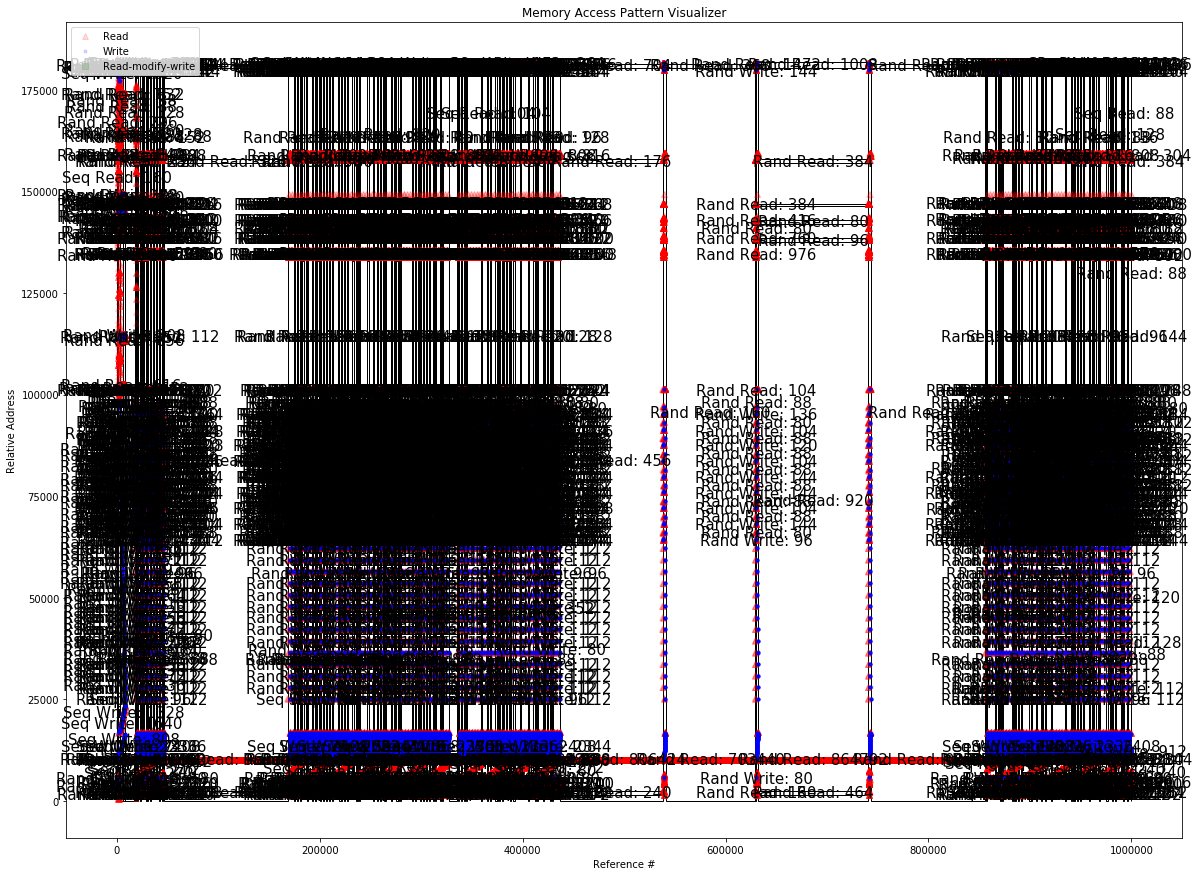

In [9]:
from enum import Enum
from bisect import bisect_left

X_CHANGE_MIN_GAP = 1000
Y_CHANGE_MIN_GAP = 1000
X_STEP = 500
Y_STEP = 1000
ELEM_TH = 10         # minimum number of elements in bucket to be considered for calculation
RW_RATIO_TH = 0.85    # read/write ratio threashold
ACCESS_SIZE = 8        # size of each access (TODO: Instead of assuming, get from PIN)
CORR_TH = 0.8       # correlation threadhold for determining rand/seq
CHANGE_TH = 0.05      # Consider a change in x axis

class RWType(Enum):
    SEQ  = 1
    RAND = 2
    NA   = 3

class AType(Enum):
    READ  = 1
    WRITE = 2
    MIXED = 3
    NA    = 4

def getXRange(startX, endX, idxIn, addrIn, rwIn, idxOut, addrOut, rwOut, inSz):
    cnt = 0
    for i in range(inSz):
        idx = idxIn[i]
        if idx >= startX and idx < endX:
            addrOut[cnt] = addrIn[i]
            rwOut[cnt] = rwIn[i]
            idxOut[cnt] = idxIn[i]
            cnt = cnt + 1
    return cnt

def getPattern(addrBkt, idxBkt, cnt):
    if cnt < ELEM_TH:        # not enough elements to decide
        return RWType.NA
    corr,_ = pearsonr(idxBkt[0:cnt], addrBkt[0:cnt])
    if corr >= CORR_TH or corr <= (-1*CORR_TH):
        return RWType.SEQ
    return RWType.RAND

def resToString(res):
    retVal = "";
    hasRead = False
    if res['rdType'] == RWType.SEQ or res['rdType'] == RWType.RAND:
        if res['rdType'] == RWType.SEQ:
            retVal = "Seq"
        elif res['rdType'] == RWType.RAND:
            retVal = "Rand"
        retVal = retVal + " Read: " + str(res['rdCnt'] * ACCESS_SIZE)
        hasRead = True
    
    if res['wrType'] == RWType.SEQ or res['wrType'] == RWType.RAND:
        if hasRead:
            retVal = retVal + '\n'
        if res['wrType'] == RWType.SEQ:
            retVal = "Seq"
        elif res['wrType'] == RWType.RAND:
            retVal = "Rand"
        retVal = retVal + " Write: " + str(res['wrCnt'] * ACCESS_SIZE)
        
    return retVal

def countRW(rwArr, start_index, end_index):
    rdCnt = 0
    wrCnt = 0
    for i in range(start_index, end_index):
        if rwArr[i] == READ_TYPE:
            rdCnt = rdCnt + 1
        elif rwArr[i] == WRITE_TYPE:
            wrCnt = wrCnt + 1
    return rdCnt, wrCnt            

def isChanged(rd1, rd2, wr1, wr2):
    diff = abs(rd1 - rd2) + abs(wr1 - wr2)
    diffRatio = diff / (rd1 + wr1)
    if diffRatio >= CHANGE_TH:
        return True, diffRatio
    return False, diffRatio

def isResChanged(prev, curr):
    # check for R/W ratio change
    #if isChanged(rd1 = prev['rdCnt'], rd2 = curr['rdCnt'], wr1 = prev['wrCnt'], wr2 = curr['wrCnt']):
    #    return True
    
    # check for rd or wr type change
    if (prev['rdType'] != curr['rdType']) or (prev['wrType'] != curr['wrType']):
        return True
    return False

def analyzeYRange(idxBkt, addrBkt, rwBkt, rdAddr, wrAddr, rdIdx, wrIdx, startY, endY, inSz):
    retVal = {'rdType': RWType.NA, 'wrType': RWType.NA, 'rdCnt': 0, 'wrCnt': 0}
    
    idxStartY = bisect_left(addrBkt, startY, hi = inSz)
    idxEndY = bisect_left(addrBkt, endY, hi = inSz)
    
    # check if enough elements in bucket
    if idxEndY - idxStartY < ELEM_TH:
        return retVal
        
    #print('StartY', startY, 'EndY:', endY, 'idxStartY', idxStartY, 'idxEndY', idxEndY)
        
    # separate read/write
    rdCnt = 0
    wrCnt = 0
    for i in range(idxStartY, idxEndY):
        if rwBkt[i] == READ_TYPE:
            rdAddr[rdCnt] = addrBkt[i]
            rdIdx[rdCnt] = idxBkt[i]
            rdCnt = rdCnt + 1
        elif rwBkt[i] == WRITE_TYPE:
            wrAddr[wrCnt] = addrBkt[i]
            wrIdx[wrCnt] = idxBkt[i]
            wrCnt = wrCnt + 1
    
    
    
    if rdCnt >= ELEM_TH:
        retVal['rdCnt'] = rdCnt
        retVal['rdType'] = getPattern(addrBkt = rdAddr, idxBkt = rdIdx, cnt = rdCnt)
    if wrCnt >= ELEM_TH:
        retVal['wrCnt'] = wrCnt
        retVal['wrType'] = getPattern(addrBkt = wrAddr, idxBkt = wrIdx, cnt = wrCnt)
        
    return retVal

################################################## CODE ##################################################

dfc = df.sort_index()
maxX = dfc.shape[0]
maxX = (int)(maxX / X_STEP) * X_STEP
maxAddr = comp_addr.conv
dfcAddr = dfc.Addr.to_numpy()
dfcRW = dfc.R0_W1.to_numpy()

plt.figure(figsize=(20,15))
ax = plt.gca()

xChanges = []
prev_rdCnt = 0
prev_wrCnt = 0
prev_x = None
maxBkt = 0
for base_x in range(0, maxX, X_STEP):
    rdCnt, wrCnt = countRW(rwArr = dfcRW, start_index = base_x, end_index = base_x + X_STEP)
    res,ratio = isChanged(rd1 = rdCnt, rd2 = prev_rdCnt, wr1 = wrCnt, wr2 = prev_wrCnt)
    if res == True:
        if prev_x != None:
            diff = base_x - prev_x
            if diff >= X_CHANGE_MIN_GAP:
                xChanges.append({'s':prev_x, 'e':base_x})
                if diff > maxBkt:
                    maxBkt = diff
        prev_x = base_x
    prev_rdCnt = rdCnt
    prev_wrCnt = wrCnt
xChanges.append({'s':prev_x, 'e':maxX})
diff = maxX - prev_x
if diff > maxBkt:
    maxBkt = diff

dfAddr = df.Addr.to_numpy()
dfRW   = df.R0_W1.to_numpy()
dfIdx  = df.index.to_numpy()
idxArr = np.zeros(maxBkt, dtype=int)
addrArr = np.zeros(maxBkt, dtype=int)
rwArr = np.zeros(maxBkt, dtype=int)
rdIdx = np.zeros(maxBkt, dtype=int)
rdAddr = np.zeros(maxBkt, dtype=int)
wrIdx = np.zeros(maxBkt, dtype=int)
wrAddr = np.zeros(maxBkt, dtype=int)

print('MaxAddr', maxAddr)
print('MaxBkt', maxBkt)

y_limit = maxAddr
#y_limit = 320000

for x in xChanges:
    print("X change detected at:", x['s'], x['e'])
    #plt.axvline(x['s'], 0, maxAddr)
    
    # cut x range
    elemCnt = getXRange(startX = x['s'], 
                        endX = x['e'],
                        idxIn = dfIdx,
                        addrIn = dfAddr,
                        rwIn = dfRW,
                        idxOut = idxArr,
                        addrOut = addrArr,
                        rwOut = rwArr,
                        inSz = maxX)
    
    prev_res = None
    yChanges = []
    prev_y = 0
    for base_y in range(0, y_limit, (int)(Y_STEP/2)):
        res = analyzeYRange(idxBkt = idxArr, 
                            addrBkt = addrArr,
                            rwBkt = rwArr,
                            rdAddr = rdAddr,
                            wrAddr = wrAddr,
                            rdIdx = rdIdx,
                            wrIdx = wrIdx,
                            startY = base_y,
                            endY = base_y + Y_STEP,
                            inSz = elemCnt)
        
        if prev_res != None:
            if isResChanged(prev_res, res):
                diff = base_y - prev_y
                if diff >= Y_CHANGE_MIN_GAP:
                    yChanges.append({'s':prev_y, 'e':base_y})
                    #plt.axhline(base_y, x['s'], x['e'])
                prev_y = base_y
        
        prev_res = res
        
    for y in yChanges:
        print('Y change at:', y['s'], y['e'])
        res = analyzeYRange(idxBkt = idxArr, 
                            addrBkt = addrArr,
                            rwBkt = rwArr,
                            rdAddr = rdAddr,
                            wrAddr = wrAddr,
                            rdIdx = rdIdx,
                            wrIdx = wrIdx,
                            startY = y['s'],
                            endY = y['e'],
                            inSz = elemCnt)
        px = x['s']
        py = y['s']
        width = x['e'] - x['s']
        height = y['e'] - y['s']
        pstr = resToString(res)
        ax.add_patch(patches.Rectangle((px,py),width,height,linewidth=1,edgecolor='k',facecolor='none'))
        plt.text(px+width/2, py + height/2, pstr, horizontalalignment='center', verticalalignment='center', fontsize = 15)  
    
# plot
plt.title("Memory Access Pattern Visualizer")
plt.xlabel("Reference #")
plt.ylabel("Relative Address")
plt.plot(dfR.index, dfR.Addr, 'r^', alpha=args_alpha_read, label='Read')
plt.plot(dfW.index, dfW.Addr, 'b.', alpha=args_alpha_write, label='Write')
plt.plot(dfRMW.index, dfRMW.Addr, 'gs', alpha=args_alpha_rmw, label='Read-modify-write')
plt.legend(loc='upper left')
plt.show()